#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [345]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [346]:
path = '/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [348]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [349]:
# 주어진 데이터 셋을 불러오세요.(3개)

data01_train = pd.read_csv(path + 'data01_train.csv')
data01_test = pd.read_csv(path + 'data01_test.csv')
features = pd.read_csv(path + 'features.csv')

# 'subject' 칼럼 삭제
data01_train.drop(columns=['subject'], inplace=True)
data01_test.drop(columns=['subject'], inplace=True)

# 결과 확인
print("Train Data Shape:", data01_train.shape)
print("Test Data Shape:", data01_test.shape)
print("Features Data Shape:", features.shape)

Train Data Shape: (5881, 562)
Test Data Shape: (1471, 562)
Features Data Shape: (561, 4)


#### 2) 기본 정보 조회

In [350]:
#전체 데이터의 행,열 개수 확인

# (1) 전체 데이터의 행, 열 개수 확인
print("\nTrain Data Shape:", data01_train.shape)
print("Test Data Shape:", data01_test.shape)
print("Features Data Shape:", features.shape)




Train Data Shape: (5881, 562)
Test Data Shape: (1471, 562)
Features Data Shape: (561, 4)


In [351]:

# (2) 전체 데이터의 상위 5개 행 확인
print("\nTrain Data Head:")
print(data01_train.head())

print("\nTest Data Head:")
print(data01_test.head())

print("\nFeatures Data Head:")
print(features.head())


Train Data Head:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288508          -0.009196          -0.103362         -0.988986   
1           0.265757          -0.016576          -0.098163         -0.989551   
2           0.278709          -0.014511          -0.108717         -0.997720   
3           0.289795          -0.035536          -0.150354         -0.231727   
4           0.394807           0.034098           0.091229          0.088489   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.962797         -0.967422         -0.989000         -0.962596   
1         -0.994636         -0.987435         -0.990189         -0.993870   
2         -0.981088         -0.994008         -0.997934         -0.982187   
3         -0.006412         -0.338117         -0.273557          0.014245   
4         -0.106636         -0.388502         -0.010469         -0.109680   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X 

In [352]:

# (3) 전체 데이터의 수치형 변수 분포 확인
print("\nTrain Data Description:")
print(data01_train.describe())

print("\nTest Data Description:")
print(data01_test.describe())


Train Data Description:
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        5881.000000        5881.000000        5881.000000   
mean            0.274811          -0.017799          -0.109396   
std             0.067614           0.039422           0.058373   
min            -0.503823          -0.684893          -1.000000   
25%             0.262919          -0.024877          -0.121051   
50%             0.277154          -0.017221          -0.108781   
75%             0.288526          -0.010920          -0.098163   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       5881.000000       5881.000000       5881.000000       5881.000000   
mean          -0.603138         -0.509815         -0.604058         -0.628151   
std            0.448807          0.501815          0.417319          0.424345   
min           -1.000000         -0.999844         -0.999

In [353]:

# (4) 전체 데이터의 모든 변수 확인
print("\nTrain Data Columns:")
print(data01_train.columns)

print("\nTest Data Columns:")
print(data01_test.columns)

print("\nFeatures Data Columns:")
print(features.columns)


Train Data Columns:
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

Test Data Columns:
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [354]:
# 데이터 분할을 합니다.

# X (features)와 y (target) 분리
X = data01_train.drop(columns=['Activity'])
y = data01_train['Activity']

X_test = data01_test.drop(columns=['Activity'])
y_test = data01_test['Activity']

# 결과 확인
print("Train Features (X):", X.shape)
print("Train Target (y):", y.shape)
print("Test Features (X_test):", X_test.shape)
print("Test Target (y_test):", y_test.shape)

Train Features (X): (5881, 561)
Train Target (y): (5881,)
Test Features (X_test): (1471, 561)
Test Target (y_test): (1471,)


### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [355]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# 결과 미리보기
print("Scaled Train Features:")
print(pd.DataFrame(X_scaled, columns=X.columns).head())

print("Scaled Test Features:")
print(pd.DataFrame(X_test_scaled, columns=X_test.columns).head())


Scaled Train Features:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.202596           0.218248           0.103371         -0.859791   
1          -0.133922           0.031040           0.192441         -0.861051   
2           0.057662           0.083408           0.011623         -0.879254   
3           0.221631          -0.449954          -0.701726          0.827624   
4           1.774887           1.316574           3.437248          1.541168   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.902765         -0.870784         -0.850437         -0.900177   
1         -0.966218         -0.918744         -0.853240         -0.964650   
2         -0.939217         -0.934495         -0.871492         -0.940565   
3          1.003249          0.637317          0.835699          1.113624   
4          0.803509          0.516570          1.455736          0.858146   

   tBodyAcc-mad()-Z  tBodyAcc-max

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [356]:
# 정수 인코딩 변환(LabelEncoder)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_test_encoded = label_encoder.transform(y_test)

# 원-핫 인코딩
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)

# 확인
print("클래스 목록:", label_encoder.classes_)
print("샘플 인코딩 결과 (Test):", y_test_encoded[:5])


클래스 목록: ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
샘플 인코딩 결과 (Test): [1 2 3 1 2]


### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [357]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)

X_train, X_val, y_train_cat_split, y_val_cat_split = train_test_split(
    X_scaled, y_train_cat, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train_cat_split:", y_train_cat_split.shape)
print("y_val_cat_split:", y_val_cat_split.shape)


X_train: (4704, 561)
X_val: (1177, 561)
y_train_cat_split: (4704, 6)
y_val_cat_split: (1177, 6)


## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [358]:
# 모델 설계

# 모델1: Hidden Layer 없이 모델 생성 함수 정의
def create_baseline_model_softmax(input_dim, num_classes):
    model = Sequential([
        Dense(num_classes, activation='softmax', input_dim=input_dim)
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

baseline_model = create_baseline_model_softmax(X_train.shape[1], num_classes)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [359]:
baseline_model = create_baseline_model_softmax(X_train.shape[1], num_classes)
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = baseline_model.fit(
    X_train, y_train_cat_split,
    validation_data=(X_val, y_val_cat_split),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6144 - loss: 0.9499 - val_accuracy: 0.9108 - val_loss: 0.2764
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9202 - loss: 0.2488 - val_accuracy: 0.9465 - val_loss: 0.1817
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9479 - loss: 0.1643 - val_accuracy: 0.9635 - val_loss: 0.1394
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9620 - loss: 0.1309 - val_accuracy: 0.9694 - val_loss: 0.1169
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9676 - loss: 0.1092 - val_accuracy: 0.9703 - val_loss: 0.1108
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9719 - loss: 0.1027 - val_accuracy: 0.9720 - val_loss: 0.1003
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9797 - loss: 0.0806 - val_accuracy: 0.9796 - val_loss: 0.0869
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9750 - loss: 0.0803 - val_accuracy: 0.

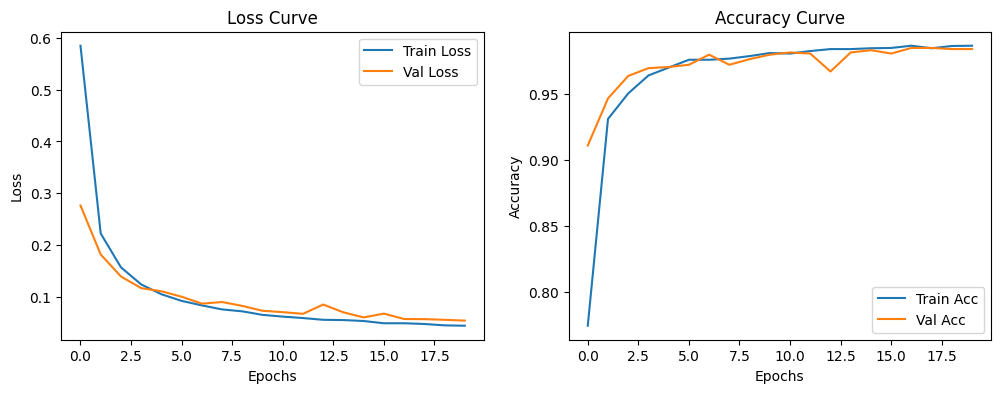

In [360]:
# 학습곡선

all_histories = [history]
last_history = all_histories[-1]

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(last_history.history['loss'], label='Train Loss')
plt.plot(last_history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(last_history.history['accuracy'], label='Train Acc')
plt.plot(last_history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



 Validation Loss: 0.0542
 Validation Accuracy: 0.9839
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Test Accuracy: 0.9708

 Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.94      0.90      0.92       254
          STANDING       0.92      0.95      0.93       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.97      1471
         macro avg       0.97      0.97      0.97      1471
      weighted avg       0.97      0.97      0.97      1471



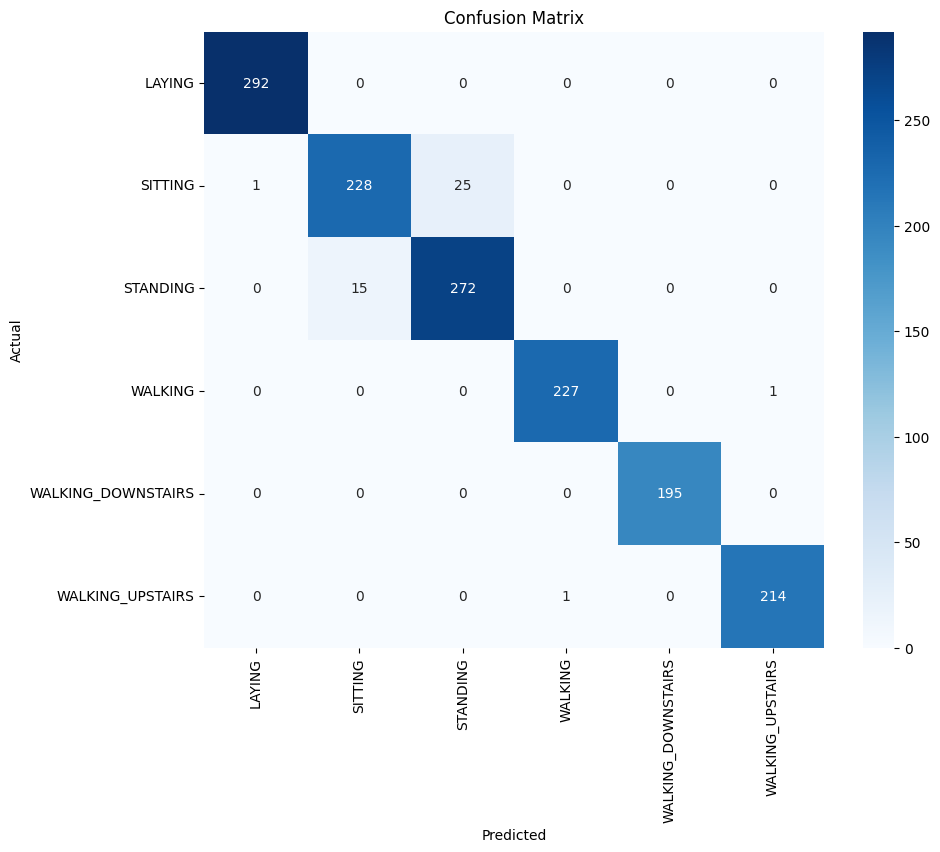

In [361]:
# 예측 및 평가


val_loss, val_accuracy = baseline_model.evaluate(X_val, y_val_cat_split, verbose=0)
print(f"\n Validation Loss: {val_loss:.4f}")
print(f" Validation Accuracy: {val_accuracy:.4f}")

# 테스트 데이터 예측
y_test_pred_prob = baseline_model.predict(X_test_scaled)
y_test_pred_classes = np.argmax(y_test_pred_prob, axis=1)

# 정확도 측정
test_accuracy = accuracy_score(y_test_encoded, y_test_pred_classes)
print(f"\n Test Accuracy: {test_accuracy:.4f}")

# 분류 리포트 출력
print("\n Classification Report:")
print(classification_report(y_test_encoded, y_test_pred_classes, target_names=label_encoder.classes_))

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



--- Run 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Run 2 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Run 3 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Run 4 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Run 5 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📌 평균 성능 결과
Validation Accuracy (avg): 0.9861
Test Accuracy (avg)      : 0.9766


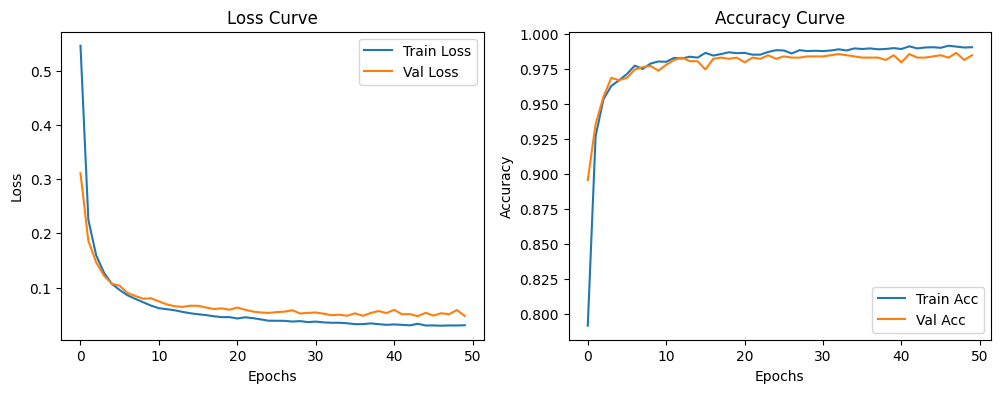


📊 최종 테스트 리포트
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.94      0.92      0.93       254
          STANDING       0.93      0.95      0.94       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.97      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.97      0.97      0.97      1471



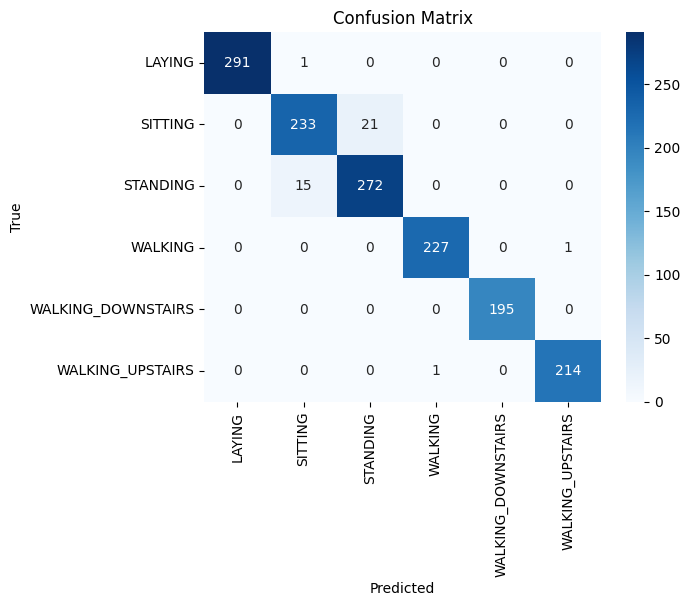

In [362]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!

# 모델 생성 함수
def create_baseline_model(input_dim, num_classes):
    model = Sequential([
        Dense(num_classes, activation='softmax', input_shape=(input_dim,))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 반복 학습 설정
num_runs = 5
val_accuracies = []
test_accuracies = []
all_histories = []

for run in range(num_runs):
    print(f"\n--- Run {run+1} ---")
    model = create_baseline_model(X_train.shape[1], y_train_cat_split.shape[1])

    history = model.fit(
        X_train, y_train_cat_split,
        validation_data=(X_val, y_val_cat_split),
        epochs=50,
        batch_size=32,
        verbose=0
    )

    # 학습 기록 저장
    all_histories.append(history)

    # 검증 정확도 저장
    val_loss, val_acc = model.evaluate(X_val, y_val_cat_split, verbose=0)
    val_accuracies.append(val_acc)

    # 테스트 예측 정확도 저장
    test_preds = model.predict(X_test_scaled)
    test_preds_classes = np.argmax(test_preds, axis=1)
    test_accuracy = accuracy_score(y_test_encoded, test_preds_classes)
    test_accuracies.append(test_accuracy)

# 평균 결과 출력
print("\n📌 평균 성능 결과")
print(f"Validation Accuracy (avg): {np.mean(val_accuracies):.4f}")
print(f"Test Accuracy (avg)      : {np.mean(test_accuracies):.4f}")

# 학습곡선 시각화 (마지막 반복 기준)
last_history = all_histories[-1]

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(last_history.history['loss'], label='Train Loss')
plt.plot(last_history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(last_history.history['accuracy'], label='Train Acc')
plt.plot(last_history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 혼동 행렬 및 리포트 출력 (마지막 반복 기준)
print("\n📊 최종 테스트 리포트")
print(classification_report(y_test_encoded, test_preds_classes, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test_encoded, test_preds_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [363]:
# 모델2 설계

def create_deep_fully_connected_model(input_dim, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

deep_fc_model = create_deep_fully_connected_model(X_train.shape[1], num_classes)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [364]:
# 컴파일 및 학습
hidden_model = create_deep_fully_connected_model(X_train.shape[1], num_classes)

hidden_model = create_hidden_model(X_train.shape[1], num_classes)
hidden_model.summary()

# 모델 구조 확인
hidden_model.summary()

# 컴파일 및 학습

hidden_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 학습
history_hidden = hidden_model.fit(
    X_train, y_train_cat_split,                     # 원-핫 인코딩된 y
    validation_data=(X_val, y_val_cat_split),       # 원-핫 인코딩된 y_val
    epochs=20,
    batch_size=32,
    verbose=2
)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_247 (Dense)               │ (None, 128)            │        71,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_247 (Dense)               │ (None, 128)            │        71,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,990 (324.18 KB)

 Trainable params: 82,990 (324.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
147/147 - 3s - 22ms/step - accuracy: 0.7800 - loss: 0.5819 - val_accuracy: 0.9473 - val_loss: 0.1357
Epoch 2/20
147/147 - 1s - 7ms/step - accuracy: 0.9541 - loss: 0.1289 - val_accuracy: 0.9618 - val_loss: 0.0970
Epoch 3/20
147/147 - 1s - 9ms/step - accuracy: 0.9641 - loss: 0.0917 - val_accuracy: 0.9779 - val_loss: 0.0615
Epoch 4/20
147/147 - 1s - 6ms/step - accuracy: 0.9758 - loss: 0.0729 - val_accuracy: 0.9737 - val_loss: 0.0705
Epoch 5/20
147/147 - 1s - 9ms/step - accuracy: 0.9807 - loss: 0.0507 - val_accuracy: 0.9771 - val_loss: 0.0640
Epoch 6/20
147/147 - 1s - 9ms/step - accuracy: 0.9804 - loss: 0.0491 - val_accuracy: 0.9788 - val_loss: 0.0657
Epoch 7/20
147/147 - 1s - 4ms/step - accuracy: 0.9862 - loss: 0.0376 - val_accuracy: 0.9864 - val_loss: 0.0500
Epoch 8/20
147/147 - 1s - 4ms/step - accuracy: 0.9866 - loss: 0.0350 - val_accuracy: 0.9482 - val_loss: 0.1251
Epoch 9/20
147/147 - 1s - 8ms/step - accuracy: 0.9834 - loss: 0.0382 - val_accuracy: 0.9873 - val_loss: 0.0431


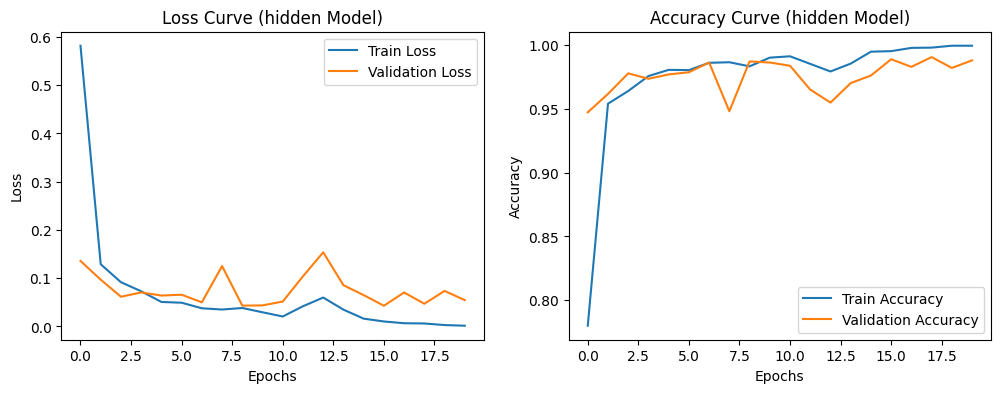

In [365]:
# 학습곡선


plt.figure(figsize=(12, 4))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(history_hidden.history['loss'], label='Train Loss')
plt.plot(history_hidden.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (hidden Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_hidden.history['accuracy'], label='Train Accuracy')
plt.plot(history_hidden.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve (hidden Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



✅ Validation Loss: 0.0545
✅ Validation Accuracy: 0.9881
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✅ Test Accuracy: 0.9769

 Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.96      0.93      0.94       254
          STANDING       0.94      0.96      0.95       287
           WALKING       0.99      0.99      0.99       228
WALKING_DOWNSTAIRS       1.00      0.99      0.99       195
  WALKING_UPSTAIRS       0.98      0.99      0.99       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



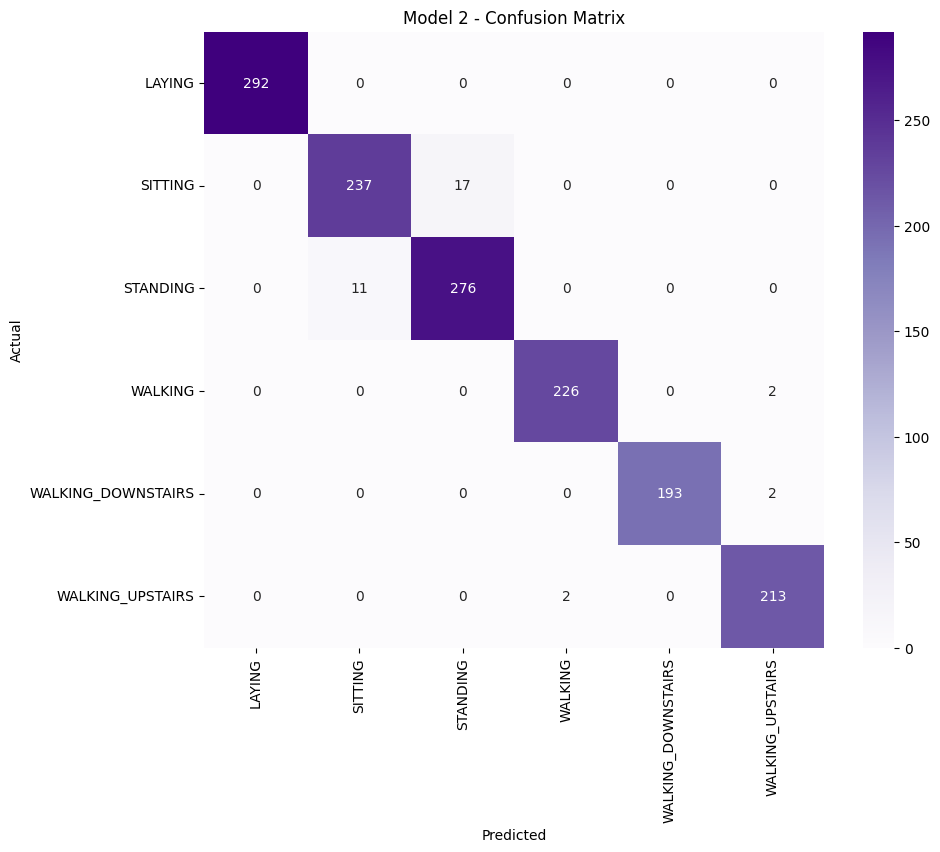

In [366]:
# 예측 및 평가

# 검증 데이터 평가
val_loss, val_accuracy = hidden_model.evaluate(X_val, y_val_cat_split, verbose=0)
print(f"\n✅ Validation Loss: {val_loss:.4f}")
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")

# 테스트 예측
y_test_pred_prob = hidden_model.predict(X_test_scaled)
y_test_pred_classes = np.argmax(y_test_pred_prob, axis=1)

# 정확도
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_accuracy = accuracy_score(y_test_encoded, y_test_pred_classes)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")

# 분류 리포트
print("\n Classification Report:")
print(classification_report(y_test_encoded, y_test_pred_classes, target_names=label_encoder.classes_))

# 혼동 행렬
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Model 2 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### (3) 모델3 : 학습률, epoch 등 조정

In [367]:
# 모델3 설계

def create_tuned_deep_model_epoch50(input_dim, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuned_deep_model_epoch50 = create_tuned_deep_model_epoch50(X_train.shape[1], num_classes)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [368]:
# 컴파일 및 학습
model_epoch50 = create_tuned_deep_model_epoch50(X_train.shape[1], num_classes)

# 2. 컴파일
model_epoch50.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. 학습
history_hidden = model_epoch50.fit(
    X_train, y_train_cat_split,                     # 원-핫 인코딩된 y
    validation_data=(X_val, y_val_cat_split),       # 원-핫 인코딩된 y_val
    epochs=50,
    batch_size=32,
    verbose=2
)


Epoch 1/50
147/147 - 3s - 19ms/step - accuracy: 0.8082 - loss: 0.5180 - val_accuracy: 0.9252 - val_loss: 0.2148
Epoch 2/50
147/147 - 1s - 4ms/step - accuracy: 0.9573 - loss: 0.1183 - val_accuracy: 0.9745 - val_loss: 0.0767
Epoch 3/50
147/147 - 1s - 5ms/step - accuracy: 0.9683 - loss: 0.0880 - val_accuracy: 0.9737 - val_loss: 0.0751
Epoch 4/50
147/147 - 1s - 8ms/step - accuracy: 0.9783 - loss: 0.0581 - val_accuracy: 0.9788 - val_loss: 0.0635
Epoch 5/50
147/147 - 1s - 5ms/step - accuracy: 0.9787 - loss: 0.0587 - val_accuracy: 0.9762 - val_loss: 0.0729
Epoch 6/50
147/147 - 1s - 5ms/step - accuracy: 0.9715 - loss: 0.0755 - val_accuracy: 0.9813 - val_loss: 0.0611
Epoch 7/50
147/147 - 1s - 10ms/step - accuracy: 0.9783 - loss: 0.0572 - val_accuracy: 0.9601 - val_loss: 0.1407
Epoch 8/50
147/147 - 1s - 6ms/step - accuracy: 0.9843 - loss: 0.0426 - val_accuracy: 0.9745 - val_loss: 0.0805
Epoch 9/50
147/147 - 1s - 8ms/step - accuracy: 0.9883 - loss: 0.0341 - val_accuracy: 0.9830 - val_loss: 0.0542

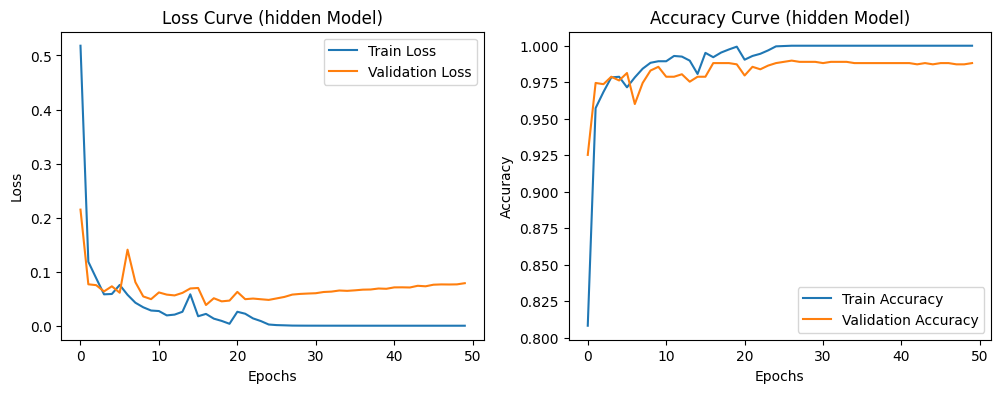

In [369]:
# 학습곡선
plt.figure(figsize=(12, 4))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(history_hidden.history['loss'], label='Train Loss')
plt.plot(history_hidden.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (hidden Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_hidden.history['accuracy'], label='Train Accuracy')
plt.plot(history_hidden.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve (hidden Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



✅ Validation Loss: 0.0545
✅ Validation Accuracy: 0.9881
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Test Accuracy: 0.9769

 Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.96      0.93      0.94       254
          STANDING       0.94      0.96      0.95       287
           WALKING       0.99      0.99      0.99       228
WALKING_DOWNSTAIRS       1.00      0.99      0.99       195
  WALKING_UPSTAIRS       0.98      0.99      0.99       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



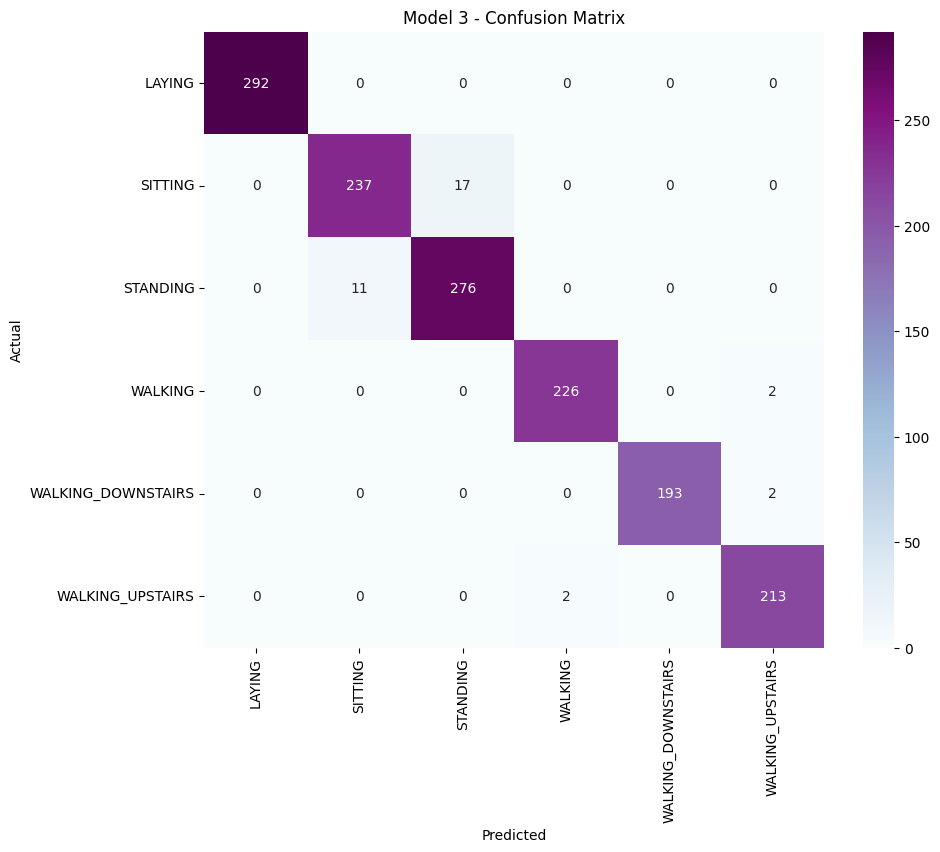

In [370]:
# 예측 및 평가

# 검증 데이터 평가
val_loss, val_accuracy = hidden_model.evaluate(X_val, y_val_cat_split, verbose=0)
print(f"\n✅ Validation Loss: {val_loss:.4f}")
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")

# 테스트 예측
y_test_pred_prob = hidden_model.predict(X_test_scaled)
y_test_pred_classes = np.argmax(y_test_pred_prob, axis=1)

# 정확도
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_accuracy = accuracy_score(y_test_encoded, y_test_pred_classes)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")

# 분류 리포트
print("\n Classification Report:")
print(classification_report(y_test_encoded, y_test_pred_classes, target_names=label_encoder.classes_))

# 혼동 행렬
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Model 3 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### (4) 모델4 :  학습률, epoch 등 조정

In [371]:
# 모델4 설계

def create_regularized_tuned_model_dropout(input_dim, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

regularized_model = create_regularized_tuned_model_dropout(X_train.shape[1], num_classes)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [372]:
# 컴파일 및 학습
from tensorflow.keras.callbacks import EarlyStopping
optimizer = Adam(learning_rate=0.001)

# ✅ 모델 객체 생성
tuned_model = create_regularized_tuned_model_dropout(X_train.shape[1], num_classes)

# ✅ 모델 컴파일
tuned_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# ✅ 모델 학습
history_tuned = tuned_model.fit(
    X_train, y_train_cat_split,
    validation_data=(X_val, y_val_cat_split),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/100
74/74 - 4s - 49ms/step - accuracy: 0.6739 - loss: 0.7967 - val_accuracy: 0.9048 - val_loss: 0.2506
Epoch 2/100
74/74 - 2s - 25ms/step - accuracy: 0.8835 - loss: 0.2898 - val_accuracy: 0.9584 - val_loss: 0.1219
Epoch 3/100
74/74 - 1s - 17ms/step - accuracy: 0.9220 - loss: 0.2004 - val_accuracy: 0.9473 - val_loss: 0.1280
Epoch 4/100
74/74 - 1s - 16ms/step - accuracy: 0.9441 - loss: 0.1549 - val_accuracy: 0.9703 - val_loss: 0.0837
Epoch 5/100
74/74 - 1s - 8ms/step - accuracy: 0.9505 - loss: 0.1299 - val_accuracy: 0.9737 - val_loss: 0.0816
Epoch 6/100
74/74 - 1s - 9ms/step - accuracy: 0.9628 - loss: 0.1067 - val_accuracy: 0.9694 - val_loss: 0.0779
Epoch 7/100
74/74 - 1s - 16ms/step - accuracy: 0.9670 - loss: 0.0913 - val_accuracy: 0.9745 - val_loss: 0.0701
Epoch 8/100
74/74 - 1s - 8ms/step - accuracy: 0.9677 - loss: 0.0954 - val_accuracy: 0.9745 - val_loss: 0.0791
Epoch 9/100
74/74 - 1s - 8ms/step - accuracy: 0.9751 - loss: 0.0690 - val_accuracy: 0.9762 - val_loss: 0.0730
Epoch

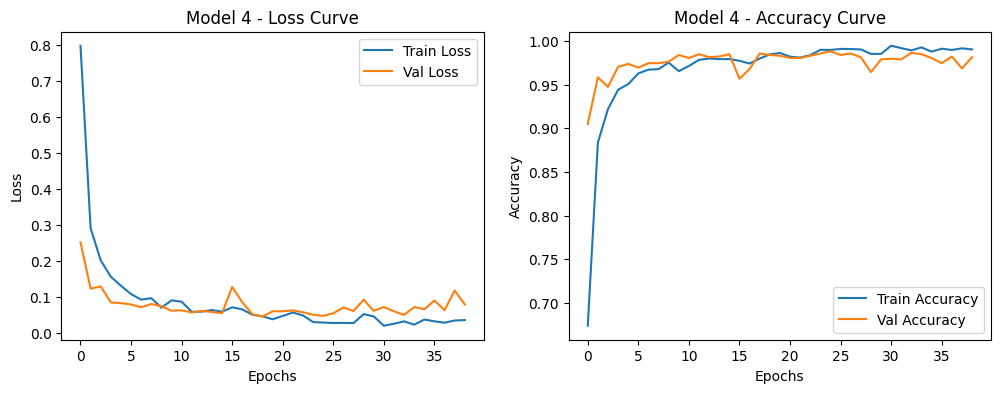

In [373]:
# 학습 곡선 시각화
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_tuned.history['loss'], label='Train Loss')
plt.plot(history_tuned.history['val_loss'], label='Val Loss')
plt.title('Model 4 - Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_tuned.history['accuracy'], label='Train Accuracy')
plt.plot(history_tuned.history['val_accuracy'], label='Val Accuracy')
plt.title('Model 4 - Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


✅ Validation Loss: 0.0443
✅ Validation Accuracy: 0.9839
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✅ Test Accuracy: 0.9755
[Regularized_Tuned_Model] Test Accuracy: 0.9755

 Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.94      0.93      0.93       254
          STANDING       0.93      0.94      0.94       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



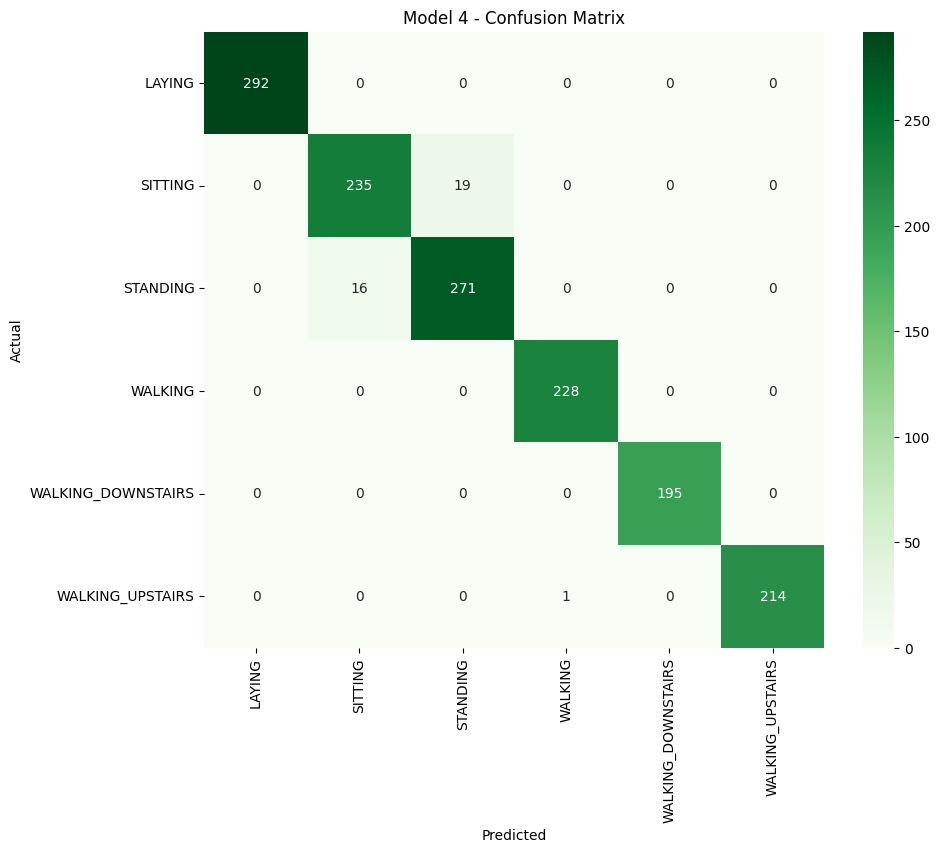

In [374]:
# 검증 데이터 평가
val_loss, val_accuracy = tuned_model.evaluate(X_val, y_val_cat_split, verbose=0)
print(f"\n✅ Validation Loss: {val_loss:.4f}")
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")

# 테스트 예측
y_test_pred_prob = tuned_model.predict(X_test_scaled)
y_test_pred_classes = np.argmax(y_test_pred_prob, axis=1)

# 정확도 평가
test_accuracy = accuracy_score(y_test_encoded, y_test_pred_classes)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
# 4. Regularized Tuned 모델 평가
regularized_test_loss, regularized_test_acc = tuned_model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"[Regularized_Tuned_Model] Test Accuracy: {regularized_test_acc:.4f}")

# 분류 리포트
print("\n Classification Report:")
print(classification_report(y_test_encoded, y_test_pred_classes, target_names=label_encoder.classes_))

# 혼동 행렬
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Model 4 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [375]:

data01_test = pd.read_csv(path + 'data01_test.csv')

# 'subject' 칼럼 삭제

data01_test.drop(columns=['subject'], inplace=True)
# x, y 분할
X_test_final = data01_test.drop('Activity', axis=1)
y_test_final = data01_test['Activity']

# x: 스케일링 (train에 fit한 scaler 사용)
X_test_final_scaled = scaler.transform(X_test_final)

# y: 정수 인코딩 (train에 fit한 encoder 사용)
y_test_final_encoded = label_encoder.transform(y_test_final)
y_test_final_cat = to_categorical(y_test_final_encoded)

In [376]:
def evaluate_model(model, name):
    print(f"\n🧪 Evaluating {name}")

    # 평가
    test_loss, test_acc = model.evaluate(X_test_final_scaled, y_test_final_cat, verbose=0)
    print(f"✅ Test Accuracy: {test_acc:.4f}")
    print(f"✅ Test Loss: {test_loss:.4f}")

    # 예측 및 지표
    y_pred_prob = model.predict(X_test_final_scaled)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)

    print("\n📄 Classification Report:")
    print(classification_report(y_test_final_encoded, y_pred_classes, target_names=label_encoder.classes_))

    # 혼동 행렬
    cm = confusion_matrix(y_test_final_encoded, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

테스트 데이터 평가 시작...
Test Data Shape: (1471, 561)
Test Target Shape: (1471, 6)
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


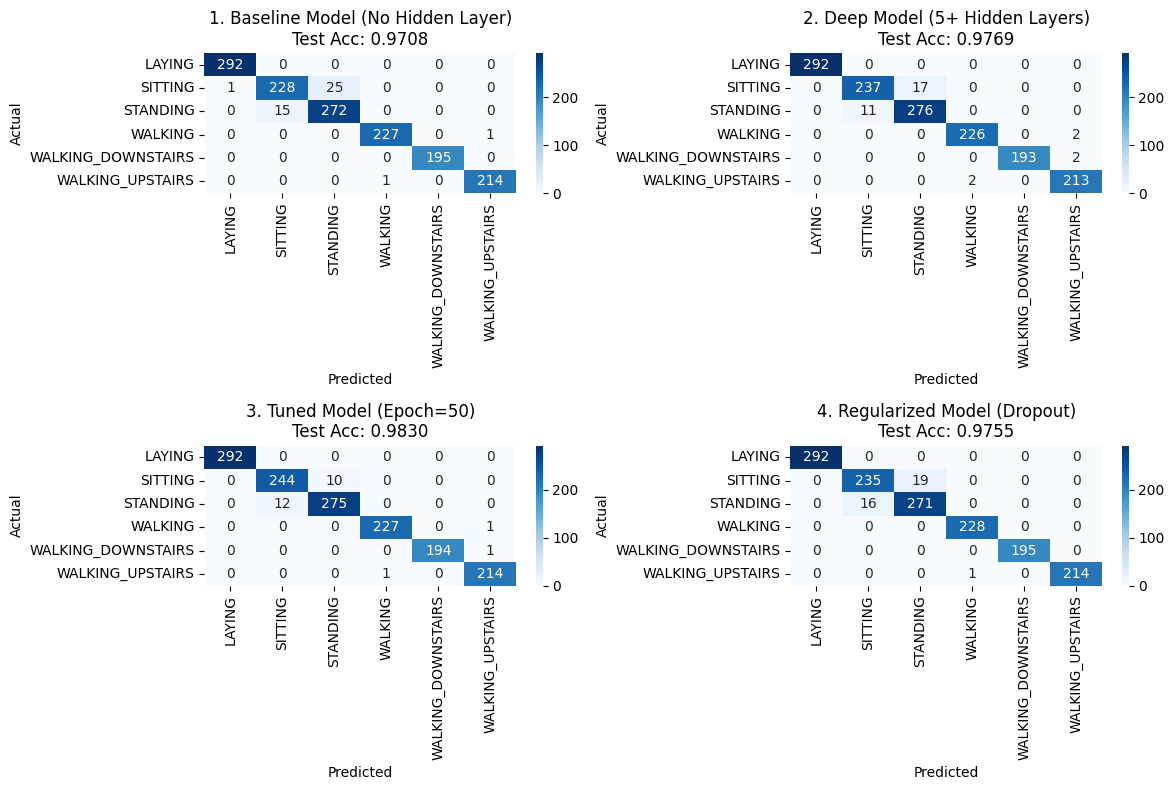

In [377]:
# 전체 데이터 불러오기(test)
print("테스트 데이터 평가 시작...")

# X_test_final_scaled, y_test_final_cat은 이미 준비되어 있음
print("Test Data Shape:", X_test_final_scaled.shape)
print("Test Target Shape:", y_test_final_cat.shape)

# 모든 모델 목록
models = {
    "1. Baseline Model (No Hidden Layer)": baseline_model,
    "2. Deep Model (5+ Hidden Layers)": hidden_model,
    "3. Tuned Model (Epoch=50)": model_epoch50,
    "4. Regularized Model (Dropout)": tuned_model
}

# 결과 저장 데이터프레임
results = {
    "Model": [],
    "Test Accuracy": [],
    "Test Loss": []
}

# 모든 모델 평가
plt.figure(figsize=(12, 8))
for i, (name, model) in enumerate(models.items()):
    # 평가
    test_loss, test_acc = model.evaluate(X_test_final_scaled, y_test_final_cat, verbose=0)

    # 결과 저장
    results["Model"].append(name)
    results["Test Accuracy"].append(test_acc)
    results["Test Loss"].append(test_loss)

    # 예측
    y_pred_prob = model.predict(X_test_final_scaled)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)

    # 혼동 행렬
    cm = confusion_matrix(y_test_final_encoded, y_pred_classes)
    plt.subplot(2, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{name}\nTest Acc: {test_acc:.4f}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()



📊 모델 성능 비교
                                 Model  Test Accuracy  Test Loss
0  1. Baseline Model (No Hidden Layer)       0.970768   0.073506
1     2. Deep Model (5+ Hidden Layers)       0.976886   0.087009
2            3. Tuned Model (Epoch=50)       0.983005   0.095037
3       4. Regularized Model (Dropout)       0.975527   0.052868


<ipython-input-378-6884e2949381>:14: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:14: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:14: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:14: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:14: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:14: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:14: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

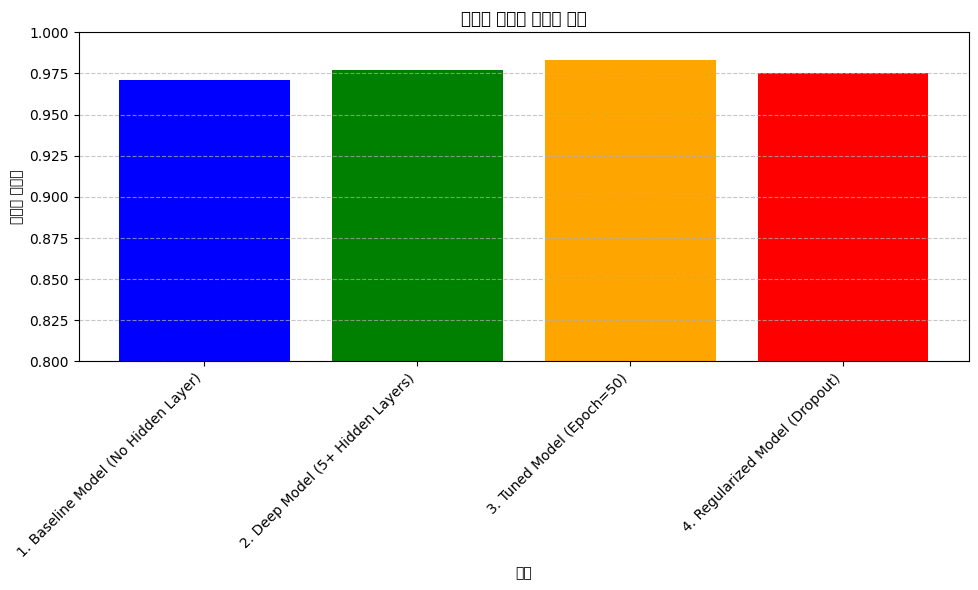


🏆 최고 성능 모델: 3. Tuned Model (Epoch=50)
   정확도: 0.9830
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📝 최고 성능 모델 상세 분석:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.95      0.96      0.96       254
          STANDING       0.96      0.96      0.96       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      0.99      1.00       195
  WALKING_UPSTAIRS       0.99      1.00      0.99       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



<ipython-input-378-6884e2949381>:45: UserWarning: Glyph 54876 (\N{HANGUL SYLLABLE HWAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:45: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:45: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:45: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:45: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:45: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-378-6884e2949381>:45: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_lay

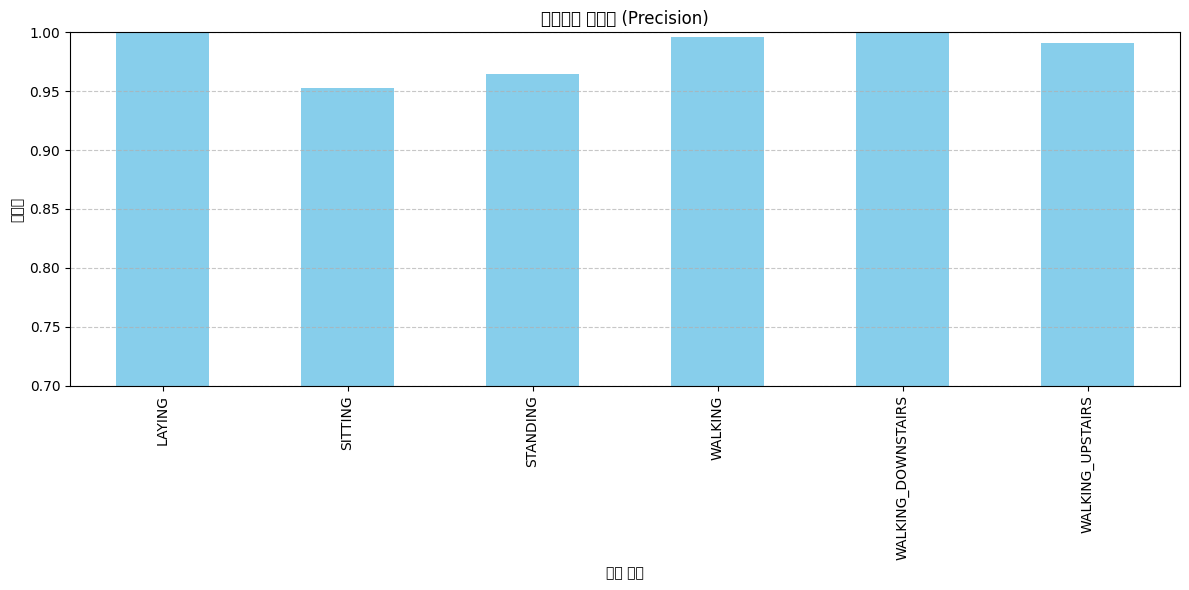


각 모델별 상세 평가:

🧪 Evaluating 1. Baseline Model (No Hidden Layer)
✅ Test Accuracy: 0.9708
✅ Test Loss: 0.0735
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📄 Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.94      0.90      0.92       254
          STANDING       0.92      0.95      0.93       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.97      1471
         macro avg       0.97      0.97      0.97      1471
      weighted avg       0.97      0.97      0.97      1471



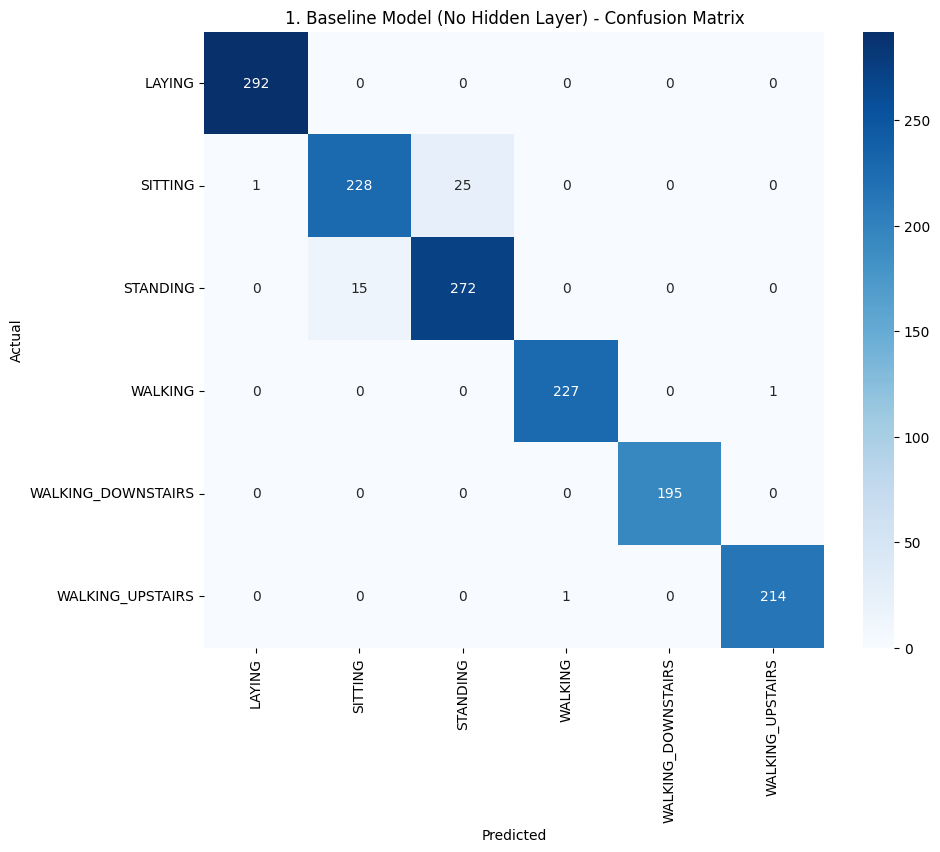


🧪 Evaluating 2. Deep Model (5+ Hidden Layers)
✅ Test Accuracy: 0.9769
✅ Test Loss: 0.0870
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📄 Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.96      0.93      0.94       254
          STANDING       0.94      0.96      0.95       287
           WALKING       0.99      0.99      0.99       228
WALKING_DOWNSTAIRS       1.00      0.99      0.99       195
  WALKING_UPSTAIRS       0.98      0.99      0.99       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



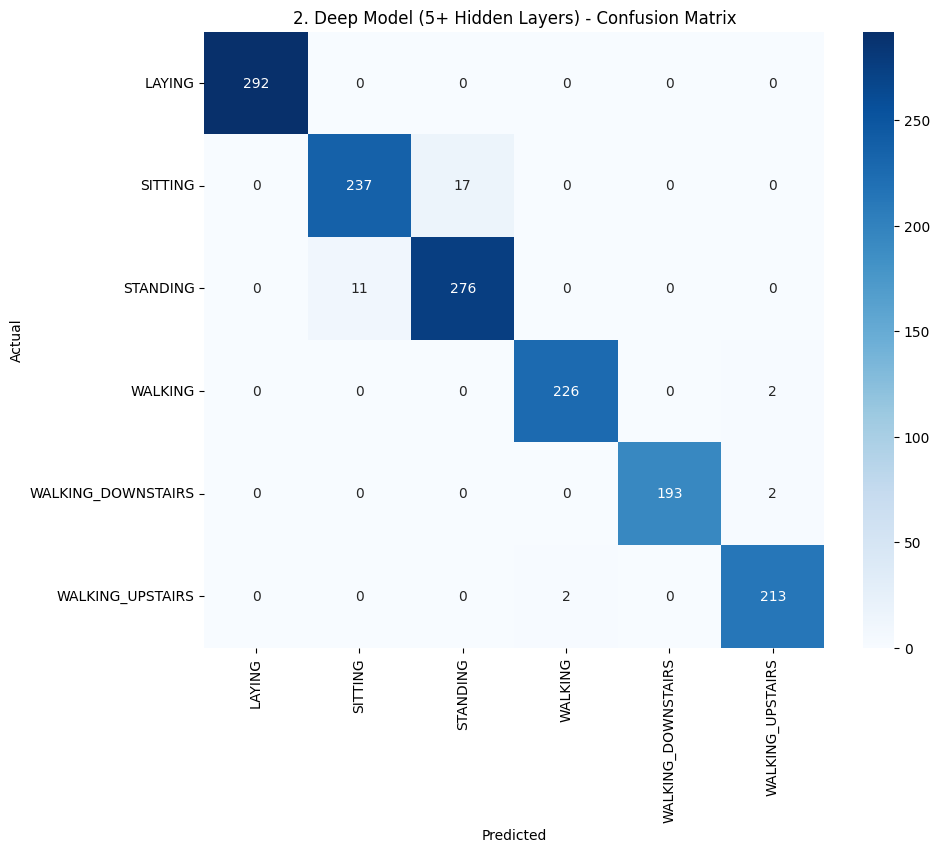


🧪 Evaluating 3. Tuned Model (Epoch=50)
✅ Test Accuracy: 0.9830
✅ Test Loss: 0.0950
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📄 Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.95      0.96      0.96       254
          STANDING       0.96      0.96      0.96       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      0.99      1.00       195
  WALKING_UPSTAIRS       0.99      1.00      0.99       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



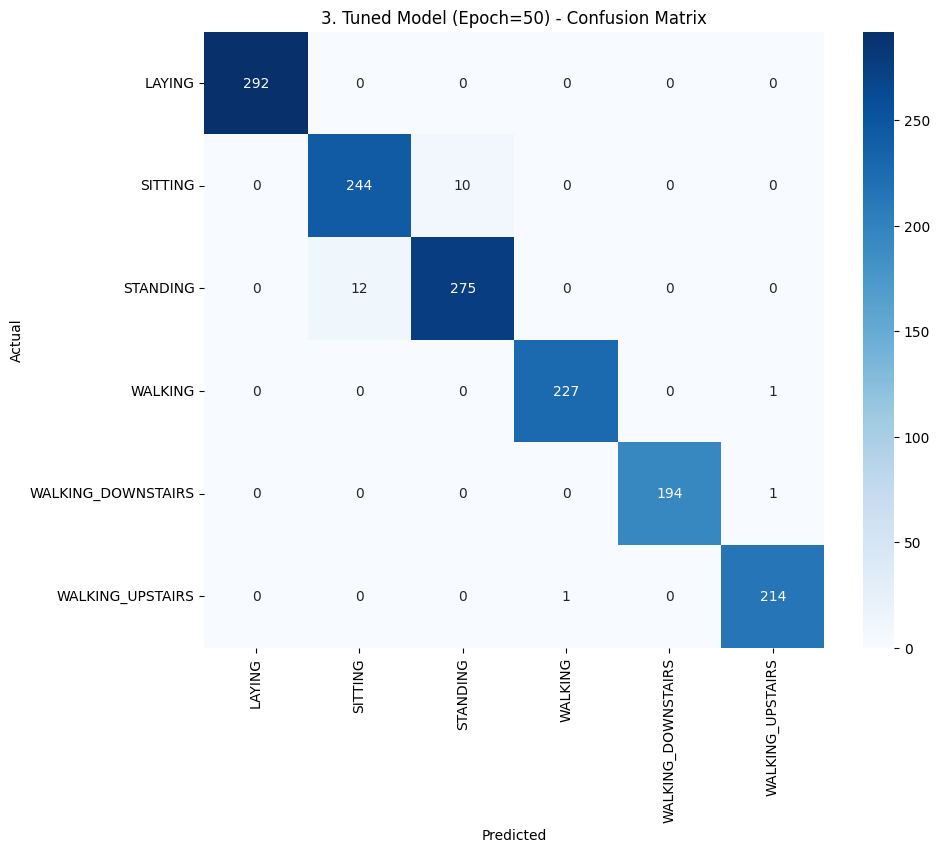


🧪 Evaluating 4. Regularized Model (Dropout)
✅ Test Accuracy: 0.9755
✅ Test Loss: 0.0529
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📄 Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.94      0.93      0.93       254
          STANDING       0.93      0.94      0.94       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



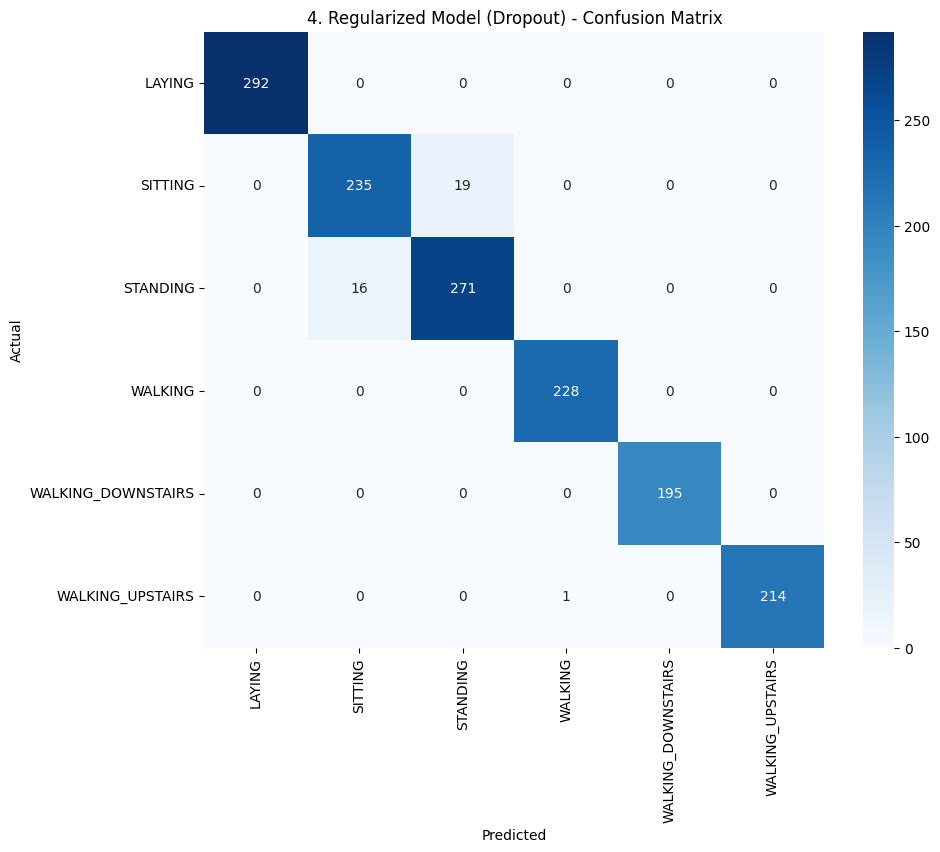

In [378]:
# 결과 데이터프레임 생성 및 출력
results_df = pd.DataFrame(results)
print("\n📊 모델 성능 비교")
print(results_df)

# 성능 시각화
plt.figure(figsize=(10, 6))
plt.bar(results["Model"], results["Test Accuracy"], color=['blue', 'green', 'orange', 'red'])
plt.title('모델별 테스트 정확도 비교')
plt.xlabel('모델')
plt.ylabel('테스트 정확도')
plt.ylim(0.8, 1.0)  # 정확도가 대부분 높을 것으로 예상되므로 범위 조정
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 최고 성능 모델 찾기
best_idx = np.argmax(results["Test Accuracy"])
best_model = results["Model"][best_idx]
best_acc = results["Test Accuracy"][best_idx]

print(f"\n🏆 최고 성능 모델: {best_model}")
print(f"   정확도: {best_acc:.4f}")

# 전체 활동 클래스별 성능 분석
best_model_obj = models[best_model]
y_best_pred = best_model_obj.predict(X_test_final_scaled)
y_best_classes = np.argmax(y_best_pred, axis=1)

print("\n📝 최고 성능 모델 상세 분석:")
print(classification_report(y_test_final_encoded, y_best_classes, target_names=label_encoder.classes_))

# 클래스별 정확도 시각화
cr = classification_report(y_test_final_encoded, y_best_classes, target_names=label_encoder.classes_, output_dict=True)
class_metrics = pd.DataFrame(cr).transpose()

plt.figure(figsize=(12, 6))
class_metrics.iloc[:-3]['precision'].plot(kind='bar', color='skyblue')
plt.title('클래스별 정밀도 (Precision)')
plt.xlabel('활동 유형')
plt.ylabel('정밀도')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

# 개별 모델 테스트 수행 (evaluate_model 함수 호출)
print("\n각 모델별 상세 평가:")
for name, model in models.items():
    evaluate_model(model, name)

#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.